In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
excel_path = Path("/Users/gagandeepsingh/Downloads/GSL_Case/GSL_LTV_MVP_dummy_base.xlsx")  # update if stored elsewhere
xls = pd.ExcelFile(excel_path)

events = pd.read_excel(xls, "events_catalog")
baselines = pd.read_excel(xls, "event_baselines")
cohorts = pd.read_excel(xls, "cohorts")
config = pd.read_excel(xls, "ltv_config")

events.head(), baselines.head(), cohorts.head(), config

(             Event                                         Definition  \
 0    session_start      App/game session begins. Core anchor for DAU.   
 1         app_open                      App opened via icon/shortcut.   
 2      push_opened   User tapped a push notification and entered app.   
 3  deeplink_opened  App opened via external link (ads, email, soci...   
 4  account_created            Account created or promoted from guest.   
 
                  Necessary payloads (stored as JSON)      Type  \
 0  player_id, timestamp, session_id, device_model...  Activity   
 1   player_id, timestamp, source (icon, notifs, ads)  Activity   
 2                  player_id, timestamp, campaign_id  Activity   
 3          player_id, timestamp, source, campaign_id  Activity   
 4                       player_id, timestamp, method  Activity   
 
   Core Revenue model                                        Purpose  
 0                All  Primary DAU event — definitive activity proof  
 1      

In [3]:
# pick one cohort row (you can change this filter)
cohort = cohorts.iloc[0].to_dict()
bm = cohort["business_model"]      # e.g., "F2P_IAP"
stage = "Early"                    # try "Mature" later

# horizon (days) to visualize – take from config or set manually
H = 90

# simple starting DAU for day 0 (you can change this)
dau_day0 = 10000

# create a placeholder date index
days = np.arange(0, H+1)  # day 0..H

In [4]:
def S_const(t, daily_churn=0.05):
    """Constant daily churn → geometric survival."""
    return (1 - daily_churn) ** t

def S_two_phase(t, churn_early=0.10, churn_late=0.03, pivot_day=7):
    """Higher churn for D0..pivot_day-1, then calmer churn afterwards."""
    t = np.array(t)
    s = np.ones_like(t, dtype=float)
    # early part
    early = np.minimum(t, pivot_day)
    s *= (1 - churn_early) ** early
    # late part
    late = np.maximum(0, t - pivot_day)
    s *= (1 - churn_late) ** late
    return s

In [5]:
S_const_curve = S_const(days, daily_churn=0.05)
S_two_curve = S_two_phase(days, churn_early=0.12, churn_late=0.03, pivot_day=5)

active_const = dau_day0 * S_const_curve
active_two   = dau_day0 * S_two_curve

pd.DataFrame({
    "day": days,
    "S_const": S_const_curve,
    "S_two_phase": S_two_curve,
    "actives_const": active_const.astype(int),
    "actives_two": active_two.astype(int)
}).head(15)

,day,S_const,S_two_phase,actives_const,actives_two
0,0,1.000000,1.000000,10000,10000
1,1,0.950000,0.880000,9500,8800
2,2,0.902500,0.774400,9025,7744
3,3,0.857375,0.681472,8573,6814
4,4,0.814506,0.599695,8145,5996
5,5,0.773781,0.527732,7737,5277
6,6,0.735092,0.511900,7350,5118
7,7,0.698337,0.496543,6983,4965
8,8,0.663420,0.481647,6634,4816
9,9,0.630249,0.467197,6302,4671


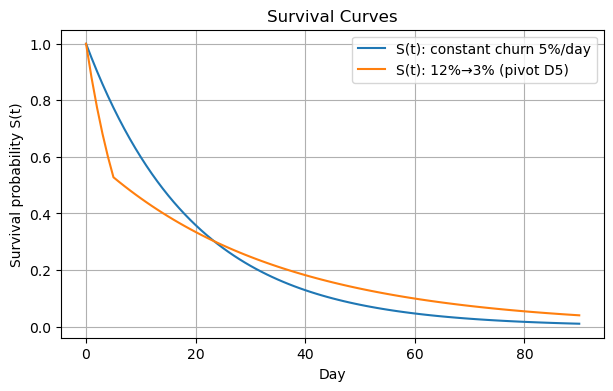

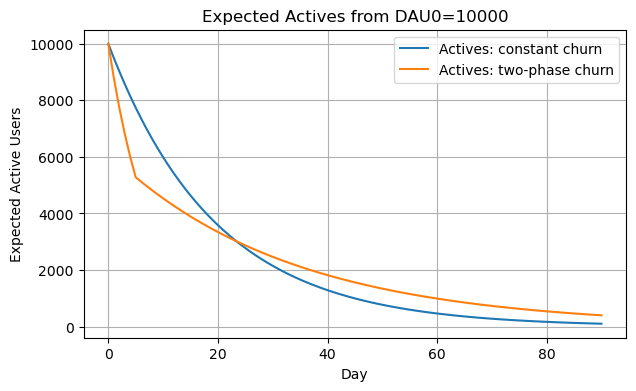

In [6]:
import matplotlib.pyplot as plt

# Plot S(t)
plt.figure(figsize=(7,4))
plt.plot(days, S_const_curve, label="S(t): constant churn 5%/day")
plt.plot(days, S_two_curve, label="S(t): 12%→3% (pivot D5)")
plt.xlabel("Day")
plt.ylabel("Survival probability S(t)")
plt.title("Survival Curves")
plt.legend()
plt.grid(True)
plt.show()

# Plot expected active users
plt.figure(figsize=(7,4))
plt.plot(days, active_const, label="Actives: constant churn")
plt.plot(days, active_two, label="Actives: two‑phase churn")
plt.xlabel("Day")
plt.ylabel("Expected Active Users")
plt.title(f"Expected Actives from DAU0={dau_day0}")
plt.legend()
plt.grid(True)
plt.show()

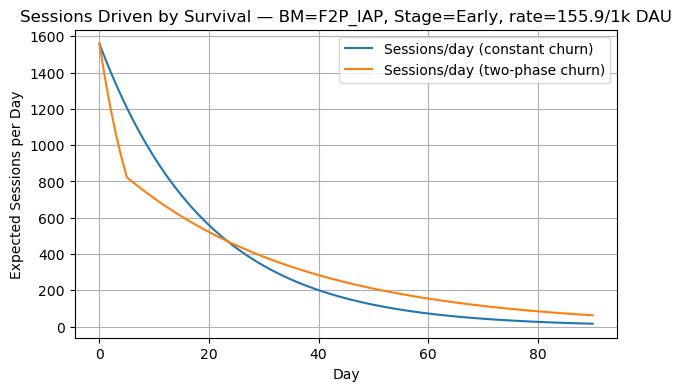

In [9]:
# pick a key activity event baseline for our business model + stage
mask = (
    (baselines["event_name"] == "session_start") &
    (baselines["business_model"] == bm) &
    (baselines["stage"] == stage)
)
row = baselines.loc[mask].iloc[0]
rate_per_1k = row["events_per_1k_DAU_per_day_mean"]  # sessions per 1k DAU per day

# expected sessions/day = (actives / 1000) * rate_per_1k
sessions_const = (active_const / 1000.0) * rate_per_1k
sessions_two   = (active_two   / 1000.0) * rate_per_1k

plt.figure(figsize=(7,4))
plt.plot(days, sessions_const, label="Sessions/day (constant churn)")
plt.plot(days, sessions_two, label="Sessions/day (two‑phase churn)")
plt.xlabel("Day")
plt.ylabel("Expected Sessions per Day")
plt.title(f"Sessions Driven by Survival — BM={bm}, Stage={stage}, rate={rate_per_1k:.1f}/1k DAU")
plt.legend()
plt.grid(True)
plt.show()

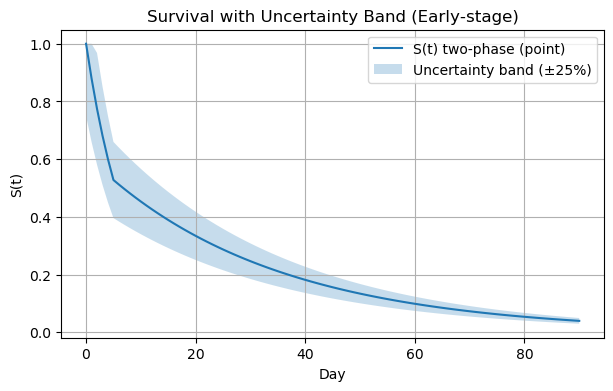

In [10]:
def band(curve, rel_width=0.2):
    """Simple ±20% band (narrower later if you want)."""
    lo = np.maximum(0, curve * (1 - rel_width))
    hi = np.minimum(1, curve * (1 + rel_width))
    return lo, hi

S_lo, S_hi = band(S_two_curve, rel_width=0.25)

plt.figure(figsize=(7,4))
plt.plot(days, S_two_curve, label="S(t) two‑phase (point)")
plt.fill_between(days, S_lo, S_hi, alpha=0.25, label="Uncertainty band (±25%)")
plt.xlabel("Day")
plt.ylabel("S(t)")
plt.title("Survival with Uncertainty Band (Early‑stage)")
plt.legend()
plt.grid(True)
plt.show()